# Notebook 1: Code for 'Identifying the phylogenetic utility of Raman spectra'

---
><font size="3"> blah blah blah All the necessary data and code for reproducing the pub are available via [GitHub](https://github.com/Arcadia-Science/raman-taxonomy).  
>
---

## Initiating workspace and loading data

In [5]:
library(here)
here::here('../') # Should be set to the root of the repository
setwd(here::here())

here() starts at /Users/ryanyork/Documents/Research/github/raman-taxonomy



[1] "/Users/ryanyork/Documents/Research/github/raman-taxonomy/../"

<font size="3"> Source functions

In [6]:
suppressPackageStartupMessages(source('01_utils/R/raman-taxonomy-utils.R'))

<font size="3"> Load spectral data and config script (contains strain name info etc.)

In [16]:
#Load Ho et al. 2019 spectral data
x = np$load('00_data/ho_et_al_2019/X_finetune.npy')

#Reverse to ensure wavenumbers are ascending
x = x[,ncol(x):1]

#Load config (contains strain name info, etc.)
config = source_python('00_data/ho_et_al_2019/config.py')

#Get names by ordering strains (have to +1 order since its 0 indexed as in python; R wants to start with 1)
n = unlist(STRAINS)

#Load wavenumbers
wav = rev(np$load('00_data/ho_et_al_2019/wavenumbers.npy'))

#Load taxonomic groups (collected from NCBI)
taxa = read.csv('00_data/ho_et_al_2019/taxonomic_groups.csv')

<font size="3"> Calculate mean spectra for all strains

In [17]:
#Calculate the mean spectra for all strains by splitting on strain and extracting column means
m = lapply(split(as.data.frame(x), y), function(z) colMeans(z))
           
#Recombine
m = do.call(rbind, m)
           
#Add rownames corresponding to strain ID
rownames(m) = n

<font size="3"> Calculate the standard error across spectra for all strains

In [18]:
#Calculate spectral standard error for all strains
se = lapply(split(as.data.frame(x), y), function(z){
  apply(z, 2, function(w) plotrix::std.error(w))
})
    
#Recombine
se = do.call(rbind, se)
    
#Add rownames corresponding to strain ID
rownames(se) = n

<font size="3"> Save means and standard errors as .RDS files

In [19]:
saveRDS(se, '01_utils/ho_et_al_spectra_se.RDS')
saveRDS(m, '01_utils/ho_et_al_spectra_means.RDS')

## Visualizing spectra (as in Figure 1)

<font size="3"> Generate taxonomic matrix that matches length of sample matrix

In [20]:
pred = as.data.frame(cbind(apply(taxa, 2, function(x) rep(x, each = 100))))

<font size="3"> Set up colors using ArcadiaColorBrewer (coloring species by genus)

In [21]:
cols = c(arcadia.pal(n = 6, name = 'Accent'), arcadia.pal(n = 6, name = 'Lighter_accents'))[1:length(unique(taxa$Genus))]
names(cols) = unique(taxa$Genus)
cols = cols[match(taxa$Genus, names(cols))]

<font size="3"> Plot all spectra and overlay mean spectrum (as in **Figure 1**)

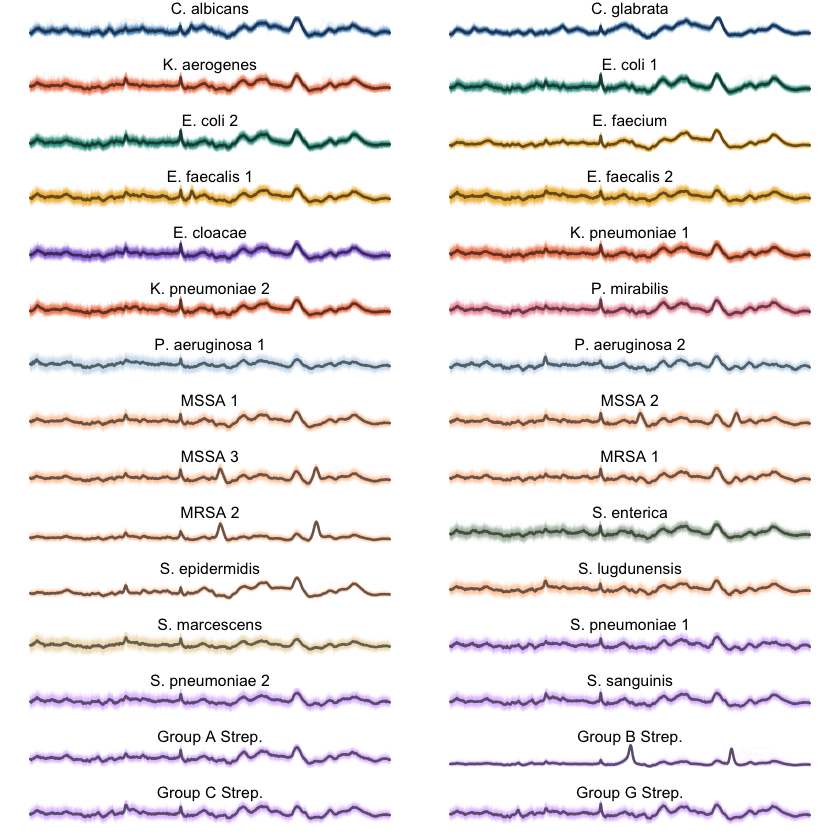

In [22]:
#Set up plot
par(mfrow = c(15,2), mar = c(1,1,1,1))

#Loop through and plot
for(i in 1:length(unique(pred$Strain))){
  
  #Extract spectra
  tmp = x[grep(unique(pred$Strain)[i], pred$Strain),]
  
  #Initiate plot
  plot(tmp[1,], col = alpha(cols[i], 0.05), type = 'l', bty = 'n', xaxt = 'n', yaxt = 'n', xlab = '', ylab = '')
  
  #Add lines
  for(j in 2:nrow(tmp)){
    lines(tmp[j,], col = alpha(cols[i], 0.05))
  }
  
  #Add mean
  lines(m[i,], lwd = 2, col = darken_color(cols[i], factor = 2))
  
  #Add label
  title(main = unique(pred$Strain)[i], font.main = 1)
  
}

## Comparing spectra as a function of taxonomic categories (as in Figure 2)

---
><font size="3"> First, we will compare spectra using **generalized linear models (GLMs)**.
>
---

<font size="3"> Reduce spectral dimensions by performing PCA

In [23]:
pca = prcomp(x)

<font size="3"> Plot variance explained

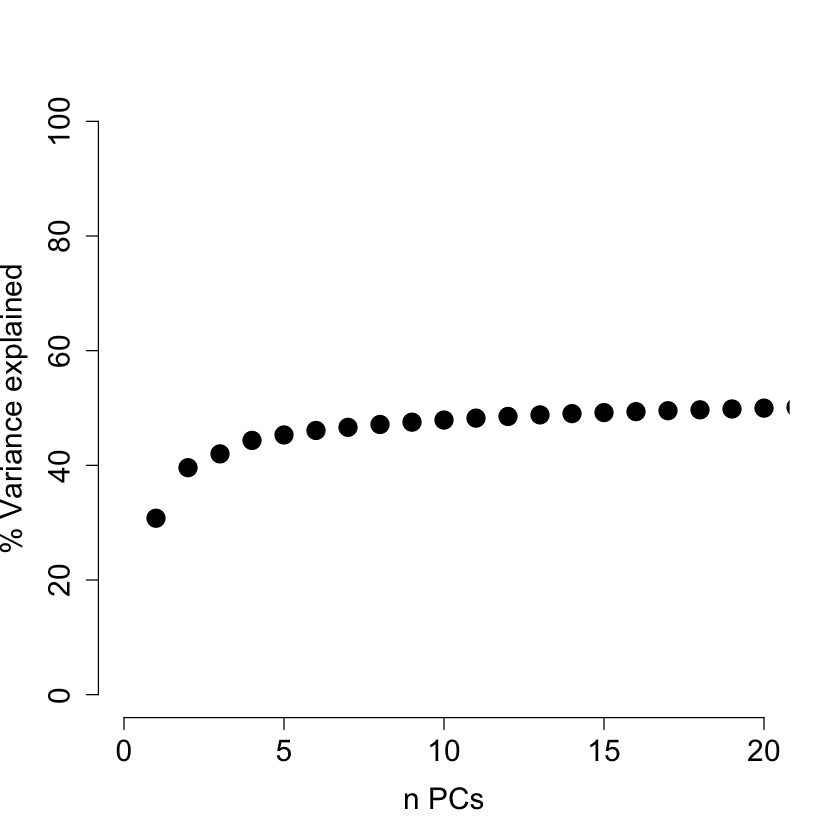

In [28]:
plot(cumsum((pca$sdev)^2/sum(((pca$sdev)^2)))[1:100]*100,
     ylab = '% Variance explained',
     xlab = 'n PCs', 
     pch = 20,
     cex = 3,
     cex.axis = 1.5, 
     cex.lab = 1.5, 
     bty = 'n', 
     xlim = c(0,20),
     ylim = c(0,100))

<font size="3"> Set up matrix of predictors (taxa) and outcome (PC1) for constructing generalized linear models (GLMs)

In [83]:
#Repeat taxonomic categories to match n samples per strain (100)
pred = as.data.frame(cbind(apply(taxa, 2, function(x) rep(x, each = 100))))

<font size="3"> Construct a GLM for each set of taxonomic predictors

In [84]:
#Generate empty list to save results
mods = list()

#Loop through and construct GLMs
for(i in 1:(ncol(pred))){
  mods[[colnames(pred)[i]]] = lm(pca$x[,1]~pred[,i])
}

<font size="3"> Calculate BIC for each model

In [90]:
bics = lapply(mods, function(x) BIC(x))

<font size="3"> Plot BICs (as in **Figure 2, B**)

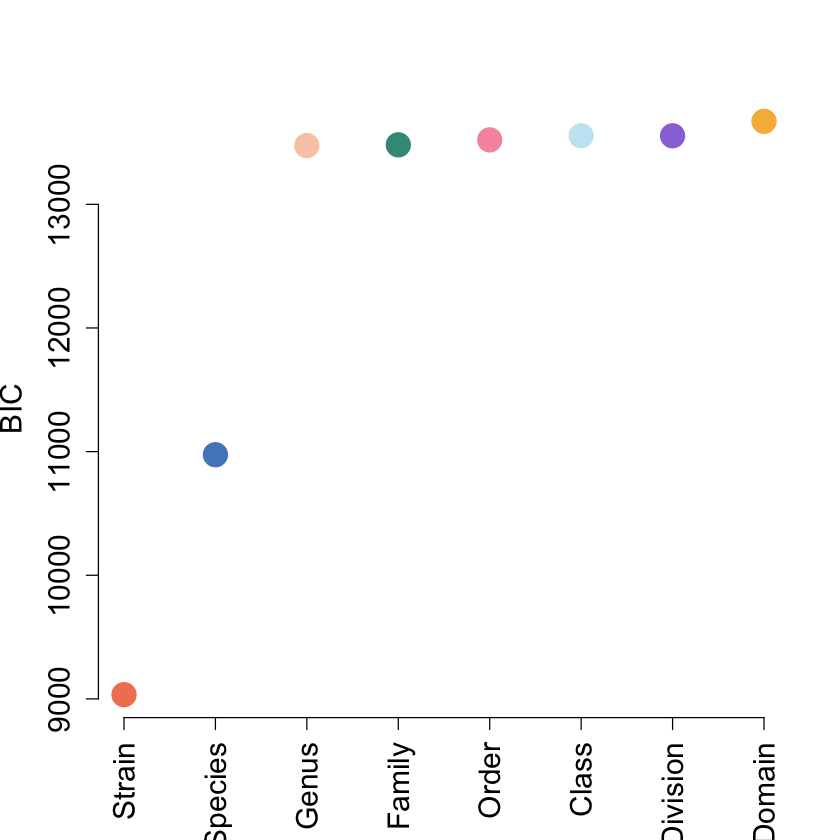

In [91]:
#Order the BIC values
bics = unlist(bics)
bics = bics[order(bics)]

#Set up colors
cols = c(arcadia.pal(n = 6, name = 'Accent'), arcadia.pal(n = 6, name = 'Lighter_accents'))[1:length(bics)]
names(cols) = c('Species', 'Strain', 'Family', 'Domain', 'Division', 'Order', 'Class', 'Genus')
cols = cols[match(names(bics), names(cols))]

#Plot
plot(bics,
     pch = 20,
     cex = 4,
     col = cols,
     ylab = 'BIC',
     xlab = '',
     cex.lab = 1.5,
     cex.axis = 1.5,
     xaxt = 'n',
     bty = 'n')

#Add axis
axis(1, 1:length(bics), names(bics), cex.axis = 1.5, las = 2)

---
><font size="3"> And now, a complementary metric, **cosine similarity**.
>
---

<font size="3"> Calculate all-by-all cosine similarity

In [47]:
d = lsa::cosine(t(x))

<font size="3"> Visualize the overall cosine similarity distribution via histogram

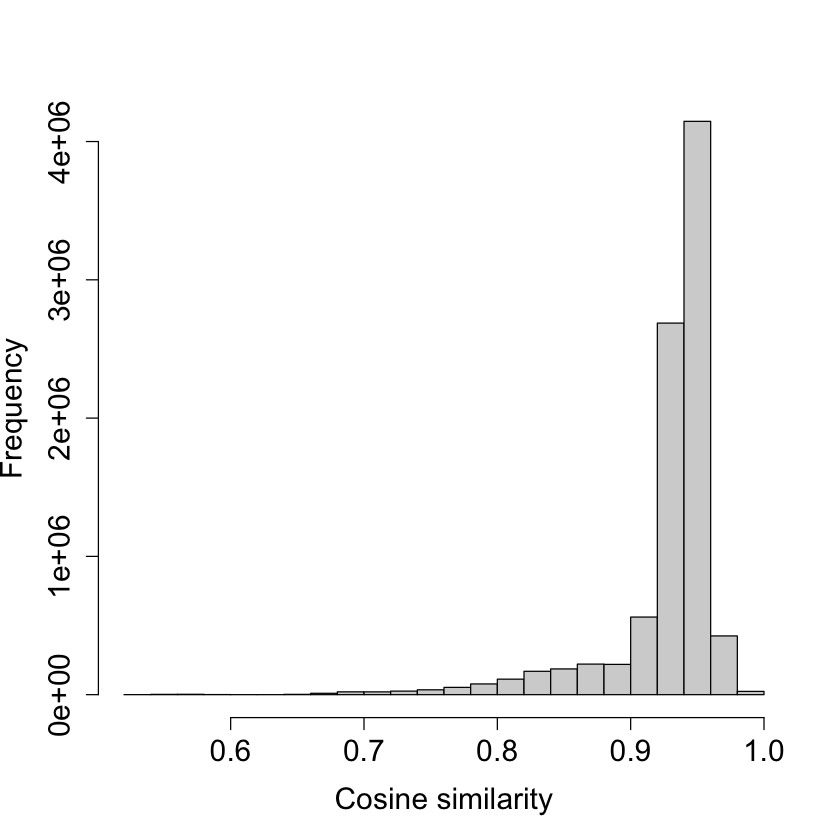

In [50]:
hist(unlist(as.data.frame(d)),
    cex.lab = 1.5,
    cex.axis = 1.5,
    xlab = 'Cosine similarity',
    main = '')

<font size="3"> Extra cosine similarities for each taxonomic group

In [98]:
#Generate empty list to save results in
res = list()

#Loop through the taxonimc group matrix ('pred') and extract cosine similarites for all associated strains
for(i in 1:(ncol(pred))){
  
  #Split cosine similarity matrix on taxonomic unit
  tmp = split(as.data.frame(d), pred[,i])
    
  #Loop through and calculate mean per strain
  for(j in 1:length(tmp)){
    tmp[[j]] = tmp[[j]][,pred[,i]%in%names(tmp)[j]]
    tmp[[j]] = tmp[[j]][!tmp[[j]] == 1]
    tmp[[j]] = mean(tmp[[j]])
  }

  #Add to results list
  res[[colnames(pred)[i]]] = unlist(tmp)
}

<font size="3"> Calculate statistics for plotting per-taxa cosine similarity

In [99]:
#Mean per group
m1 = unlist(lapply(res, function(y) mean(y)))
                   
#Standard error
se1 = unlist(lapply(res, function(y) plotrix::std.error(y)))

#Variance
v1 = unlist(lapply(res, function(y) var(y)))

<font size="3"> Plot per-taxa variance (as in **Figure 2, C**)

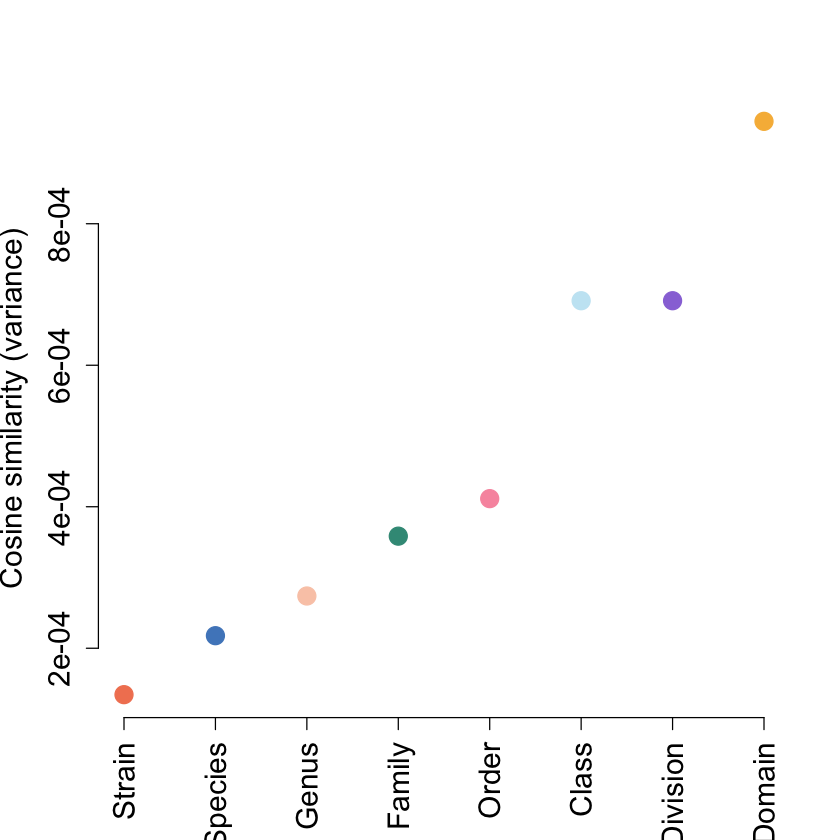

In [100]:
o = order(v1)
cols = c(arcadia.pal(n = 6, name = 'Accent'), arcadia.pal(n = 6, name = 'Lighter_accents'))[1:length(v1)]
names(cols) = c('Species', 'Strain', 'Family', 'Domain', 'Division', 'Order', 'Class', 'Genus')
cols = cols[match(names(v1[o]), names(cols))]
plot(v1[o],
     pch = 20,
     cex = 3,
     col = cols,
     #ylim = c(0.92, 0.97),
     ylab = 'Cosine similarity (variance)',
     xlab = '',
     cex.lab = 1.5,
     cex.axis = 1.5,
     xaxt = 'n',
     bty = 'n')
axis(1, 1:length(v1), names(v1)[o], cex.axis = 1.5, las = 2)

## Calculating and analyzing phylogenetic signal (as in Figure 3)

---
><font size="3"> To facilitate phylogenetic comparisons, we will first calculate phylogenetic signal as a function of spectral position.
>
---

<font size="3"> Load phylogeny (downloaded from **timetree.org** using a taxa name query)

In [92]:
phylo = read.newick('00_data/ho_et_al_2019/ho_2019_species_list_for_timetree.nwk')

<font size="3"> Drop *Streptococcus agalactiae* as its spectrum appears to be a major outlier, possibly an experimental artifact

In [94]:
phylo = drop.tip(phylo, 'Streptococcus_agalactiae')

<font size="3"> Calculate mean spectra per species that match the phylogeny

In [101]:
#Split the mean spetrum matrix on species name 
m2 = split(as.data.frame(m), paste(taxa$Genus, taxa$Species, sep = '_'))

#Calculate mean spectra by species
m2 = lapply(m2, function(x) colMeans(x))

#Recombine
m2 = do.call(rbind, m2)
            
#Remove Streptococcus agalactiae
m2 = m2[!rownames(m2) == 'Streptococcus_agalactiae',]

<font size="3"> Perform PCA on spectral means

In [103]:
pca = prcomp(m2)

<font size="3"> Compute phylogenetic signal within windows of size *n* along the spectrum

In [105]:
#Set length
len = 25

#Extract spectral windows of desired size using the function 'split_with_overlap'
win = split_with_overlap(t(m2), len, len-1)[1:(ncol(m2)-len)]

#Generate empty list for saving results
win_phy = list()

#Loop and calculate phylogenetic signal
for(i in 1:length(win)){
    
  #Reduce the dimensions of spectra in the window from size n to 1 via PCA
  p = prcomp(t(win[[i]]))
  
  #Match PCA results with phylogeny ordering
  p = p$x[match(phylo$tip.label, rownames(p$x)),2]
  
  #Reduce the dimensions of spectra in the window from size n to 1 via calculating the mean
  mn = colMeans(win[[i]])
    
  #Compute phylogenetic signal using spectral means
  mn = phylosig(phylo, mn, method = 'lambda')[1]$lambda

  #Compute phylogenetic signal using PC1
  p = phylosig(phylo, p, method = 'lambda')[1]$lambda

  #Combine into a list
  l = list(mn, p)
    
  #Add names
  names(l) = c('mean', 'pca')
    
  #Add to results list
  win_phy[[as.character(i)]] = l
}

#Extract results for PC ('pc') and spectral mean ('mn') metrics
pc = unlist(lapply(win_phy, function(x) x$pca))
mn = unlist(lapply(win_phy, function(x) x$mean))

<font size="3"> Plot window-based phylogenetic signal (as in **Figure 3, A**)

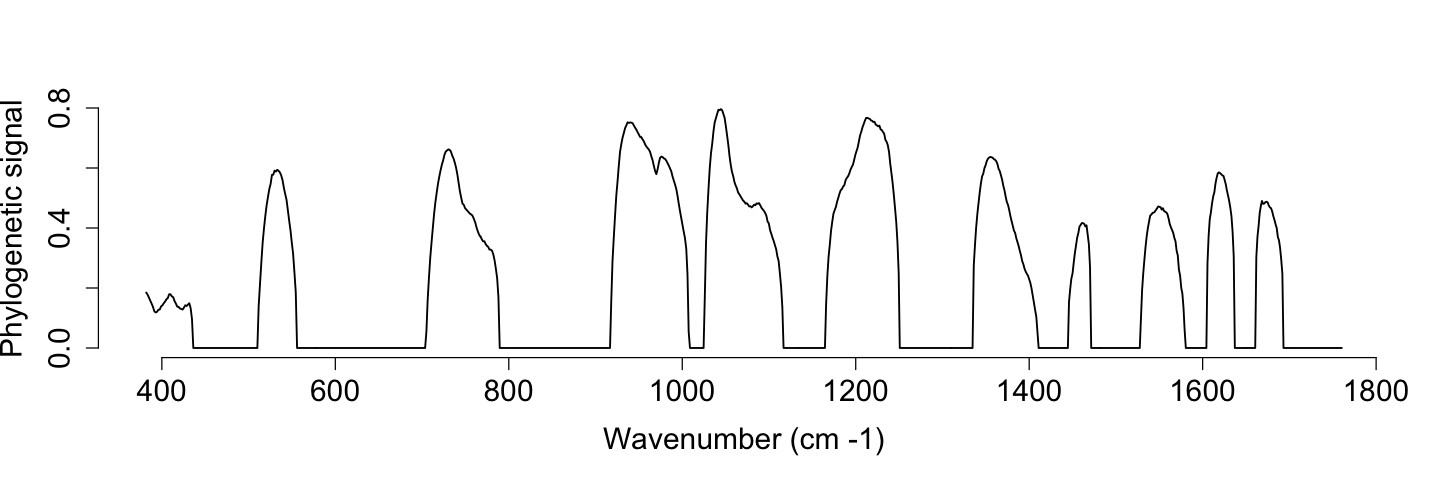

In [109]:
options(repr.plot.width=12, repr.plot.height=4)
plot(wav[1:length(mn)],
     mn,
     type = 'l',
     lwd = 1.5,
     bty = 'n',
     ylim = c(0,0.8),
     cex.axis = 1.5,
     cex.lab = 1.5,
     ylab = 'Phylogenetic signal',
     xlab = 'Wavenumber (cm -1)')

---
><font size="3"> How do spectral relationships vary as a function of evolutionary time?
>
---

<font size="3"> Calculate spectral distance as a function of position

In [113]:
#Set length
len = 25

#Extract spectral windows of desired size using the function 'split_with_overlap'
win = split_with_overlap(t(m2), len, len-1)[1:(ncol(m2)-len)]

#Generate empty list for saving results
win_dist = list()

#Loop and calculate phylogenetic signal
for(i in 1:length(win)){
    
  #Calculate distance between strains
  p = as.matrix(dist(t(win[[i]])))
  
  #Add to results list
  win_dist[[as.character(i)]] = unlist(as.data.frame(p))
}

#Combine results in matrix
win_dist = do.call(cbind, win_dist)

Calculate cophenic distances as a function of time

In [ ]:
#Generate empty list to save results
cophen_times = list()

#Loop and calculate cophenic distance in windows
for(i in 1:length(win)){
    
  #Empty list to save results
  res = list()
  
  #Calculate distance in window
  d = as.matrix(dist(t(win[[i]])))
    
  #Convert to three column matrix
  d = as.data.frame(as.table(d))

  #Looop through and calculate as a function of time
  for(j in 0:round(max(p$Freq))){
    
    #Filter on cophenetic distances
    z = d[which(p$Freq>=j),]
    
    #Remove self comparisons
    z = z[!z[,1] == z[,2],]
    
    #Add to list
    res[[as.character(j)]] = z
  }
  
  #Calculate mean
  p_mean = unlist(lapply(res, function(x) mean(x$Freq)))

  #Add to list
  cophen_times[[as.character(i)]] = p_mean
}
                         
#Combine into matrix
time_mat = do.call(cbind, cophen_times)

<font size="3"> Plot as heatmap

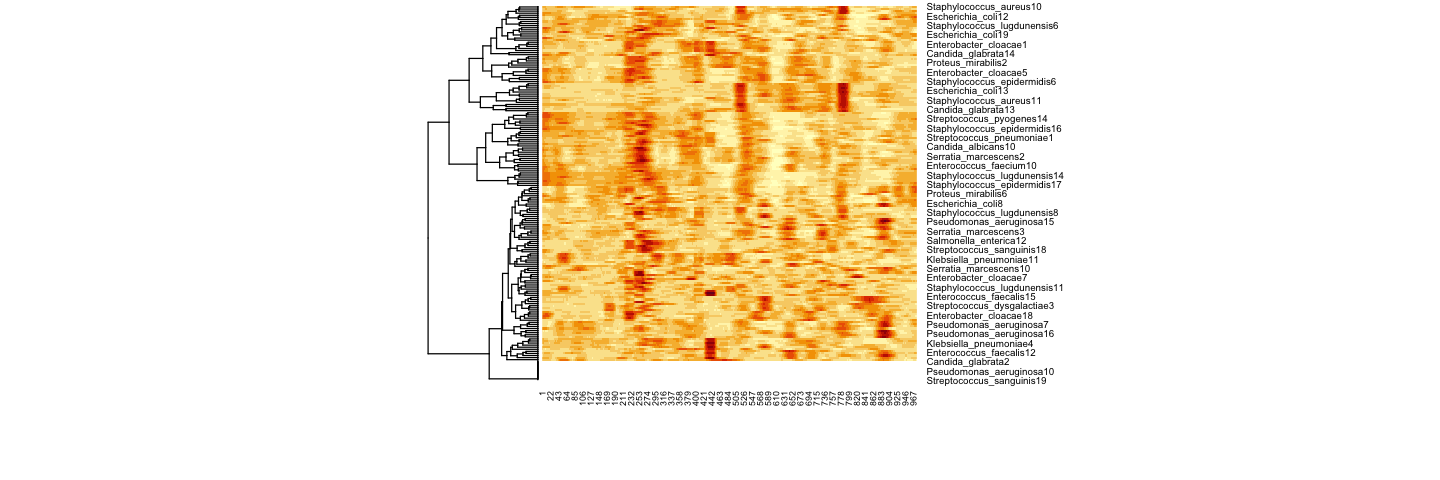

In [117]:
#Heatmap
image(t(time_mat), xaxt = 'n', yaxt = 'n', bty = 'n')

#Add line corresponding to max distance
lines(unlist(lapply(cophen_times, function(x) which.max(x))))